# Import Libraries

In [1]:
pip install rdkit openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 12.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
from csv import excel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Load Data

In [4]:
# mount drive
drive.mount('/content/drive')

# set working directory
os.chdir('/content/drive/MyDrive/Solubility')

Mounted at /content/drive


In [5]:
# load data from Ulrich et al Github repo
url = 'https://github.com/nadinulrich/log_Sw_prediction/raw/main/dataset.xlsx'
excel_file = pd.ExcelFile(url)

# view excel sheet names
print(excel_file.sheet_names)

['dataset_initial', 'dataset_split', 'predictions_test_set', 'predictions_E_set', 'predictions_delaney']


In [6]:
# get data from excel sheet 'dataset_initial'
solubility_raw_data = pd.read_excel(url, sheet_name='dataset_initial', engine='openpyxl')
solubility_raw_data.head()
print("Raw data shape:", solubility_raw_data.shape)

Raw data shape: (12236, 22)


# EDA

In [ ]:
# check distribution of label
solubility_raw_data['log Sw dataset used'].describe()

,log Sw dataset used
count,12236.000000
mean,-2.941349
std,2.315594
min,-13.171900
25%,-4.357625
50%,-2.660900
75%,-1.300000
max,3.050000


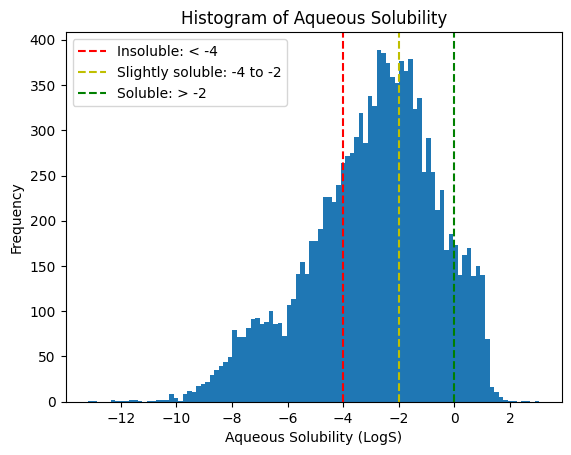

In [ ]:
# plot histogram of label
plt.hist(solubility_raw_data['log Sw dataset used'], bins=100)
plt.xlabel('Aqueous Solubility (LogS)')
plt.ylabel('Frequency')
plt.title('Histogram of Aqueous Solubility')
plt.axvline(x=-4, color='r', linestyle='--')
plt.axvline(x=-2, color='y', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
# add legend for regions of the histogram delineated by vertical lines
plt.legend(['Insoluble: < -4', 'Slightly soluble: -4 to -2', 'Soluble: > -2'])
plt.show()

[16:56:56] unsupported number of radical electrons 4


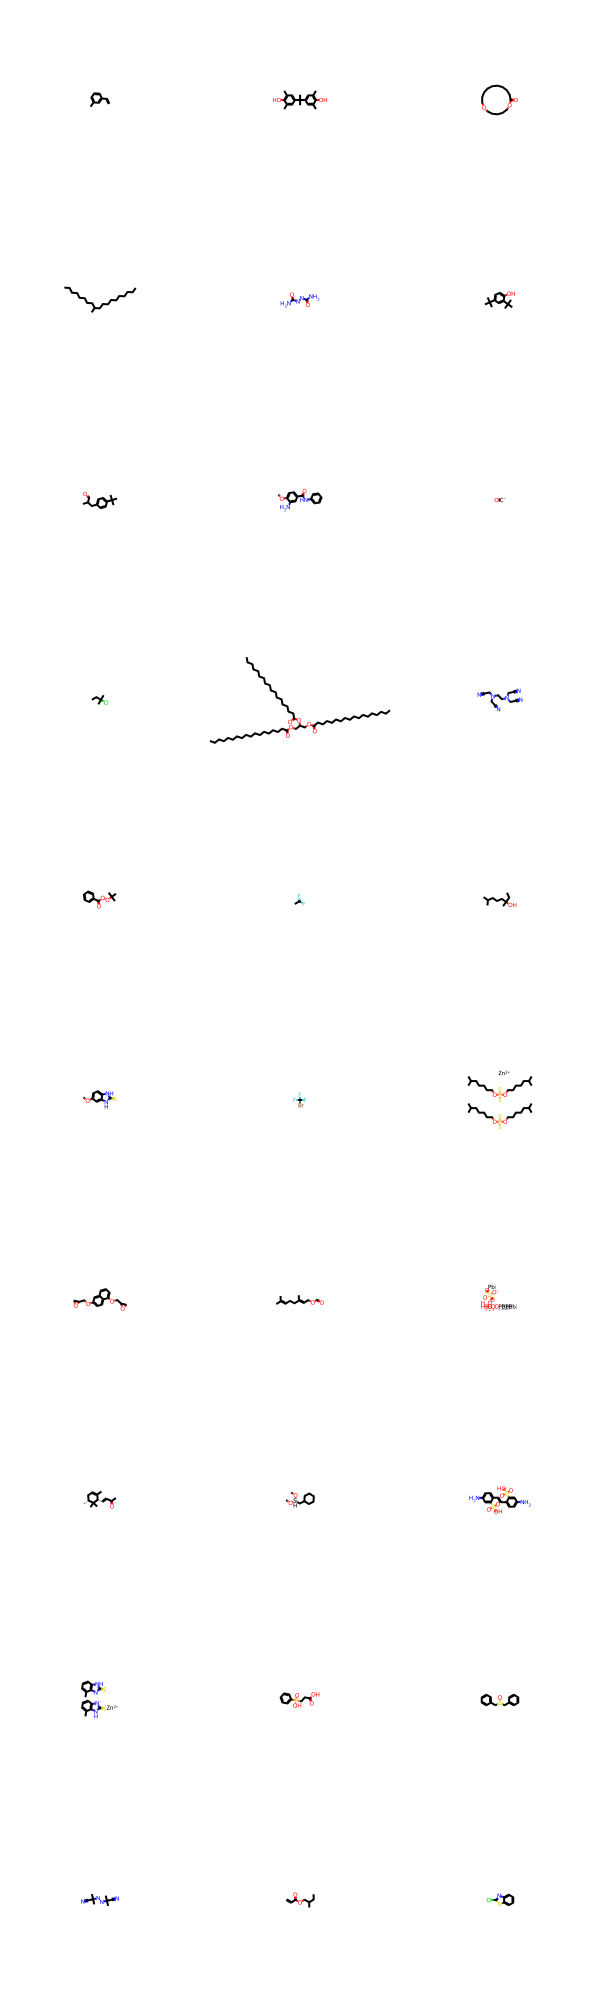

In [ ]:
# visualize sampled molecules from dataset
mols = solubility_raw_data[['SMILES']][:30]
mols['Drug_mols'] = mols['SMILES'].apply(Chem.MolFromSmiles)
Draw.MolsToGridImage(mols['Drug_mols'], molsPerRow=3, subImgSize=(200, 200))

# Preprocessing

In [7]:
# filter out compounds according to Ulrich et al methodology, indicated by 'remove' column
solubility_data_filtered = solubility_raw_data[solubility_raw_data['remove'].isna()]
print(f"Original dataset: {solubility_raw_data.shape}")
print(f"After filtering: {solubility_data_filtered.shape}")

Original dataset: (12236, 22)
After filtering: (9800, 22)


In [8]:
# keep only smiles and target columns
solubility_target = solubility_data_filtered[['SMILES', 'log Sw dataset used']]
solubility_target.columns = ['Drug', 'Y']
solubility_target.head()

,Drug,Y
1,Cc1cc(cc(C)c1O)C(C)(C)c2cc(C)c(O)c(C)c2,-4.952869
2,O=C1CCCCCCCCCOCCCCCO1,-3.883849
4,NC(=O)N=NC(N)=O,-3.546243
5,CC(C)(C)c1ccc(O)c(c1)C(C)(C)C,-3.796046
6,CC(Cc1ccc(cc1)C(C)(C)C)C=O,-3.791782


## Feature engineering

In [9]:
# use RDKit to calculate all molecular descriptors from Descriptors module
def compute_descriptors(smiles):

  try:
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
      print(f"Invalid SMILES {smiles}")
      return None

    descriptor_vals = {name: func(mol) for name, func in Descriptors.descList}
    return descriptor_vals

  except Exception as e:
    print(f"Error computing descriptors for {smiles}: {e}")
    return None

In [10]:
# apply compute_descriptors function
descriptor_df = solubility_target['Drug'].apply(compute_descriptors).apply(pd.Series)

# remove missing rows corresponding to invalid molecules
descriptor_df = descriptor_df.dropna()
print(f"After removing missing rows: {descriptor_df.shape}")

[20:16:32] Explicit valence for atom # 23 C, 5, is greater than permitted


Invalid SMILES CCCCC[C@@H](C=C[C@H]1[C@@H](O)C[C@@H]([C@@H]1CC=CCCCC(=O)O[C](=O)(NC(=O)[C@H](Cc1ccc(cc1)O)N)C)O)O


[20:16:34] Explicit valence for atom # 9 O, 4, is greater than permitted


Invalid SMILES CCN(c1ccc2c(c1)[O](=c1c(=N2)c(cc(c1O)O)C(=O)N)Cl)CC
After removing missing rows: (9798, 217)


In [11]:
# remove invalid molecules from original df
invalid_smiles = [
    'CCCCC[C@@H](C=C[C@H]1[C@@H](O)C[C@@H]([C@@H]1CC=CCCCC(=O)O[C](=O)(NC(=O)[C@H](Cc1ccc(cc1)O)N)C)O)O',
    'CCN(c1ccc2c(c1)[O](=c1c(=N2)c(cc(c1O)O)C(=O)N)Cl)CC'
]
solubility_target = solubility_target[~solubility_target['Drug'].isin(invalid_smiles)].reset_index(drop=True)
print(f"After removing invalid molecules: {solubility_target.shape}")

After removing invalid molecules: (9798, 2)


In [ ]:
# print features
for col in descriptor_df.columns:
  print(col)

MaxAbsEStateIndex
MaxEStateIndex
MinAbsEStateIndex
MinEStateIndex
qed
SPS
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
NumRadicalElectrons
MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
AvgIpc
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n
Chi1v
Chi2n
Chi2v
Chi3n
Chi3v
Chi4n
Chi4v
HallKierAlpha
Ipc
Kappa1
Kappa2
Kappa3
LabuteASA
PEOE_VSA1
PEOE_VSA10
PEOE_VSA11
PEOE_VSA12
PEOE_VSA13
PEOE_VSA14
PEOE_VSA2
PEOE_VSA3
PEOE_VSA4
PEOE_VSA5
PEOE_VSA6
PEOE_VSA7
PEOE_VSA8
PEOE_VSA9
SMR_VSA1
SMR_VSA10
SMR_VSA2
SMR_VSA3
SMR_VSA4
SMR_VSA5
SMR_VSA6
SMR_VSA7
SMR_VSA8
SMR_VSA9
SlogP_VSA1
SlogP_VSA10
SlogP_VSA11
SlogP_VSA12
SlogP_VSA2
SlogP_VSA3
SlogP_VSA4
SlogP_VSA5
SlogP_VSA6
SlogP_VSA7
SlogP_VSA8
SlogP_VSA9
TPSA
EState_VSA1
EState_VSA10
EState_VSA11
EState_VSA2
EState_VSA3
EState_VSA4
EState_VSA5
EState_VSA6
EState_

## Feature Selection

In [12]:
# remove functional group descriptors
df_filtered = descriptor_df.drop(descriptor_df.filter(regex='^fr_').columns, axis=1)
print(f"After removing functional group descriptors: {df_filtered.shape}")

# remove all VSA descriptors
df_filtered = df_filtered.drop(df_filtered.filter(regex='VSA').columns, axis=1)
print(f"After removing VSA descriptors: {df_filtered.shape}")

# remove Chi descriptors
df_filtered = df_filtered.drop(df_filtered.filter(regex='Chi').columns, axis=1)
print(f"After removing Chi descriptors: {df_filtered.shape}")

# remove other redundant features based on domain knowledge and high correlation
redundant_descriptors = [
    'MaxAbsEStateIndex',
    'MinAbsEStateIndex',
    'ExactMolWt',
    'HeavyAtomMolWt',
    'HeavyAtomCount',
    'NumValenceElectrons',
    'NumRadicalElectrons',
    'NumAliphaticHeterocycles',
    'NumAliphaticCarbocycles',
    'NumAliphaticRings',
    'NumAromaticHeterocycles',
    'NumSaturatedHeterocycles',
    'NumSaturatedCarbocycles',
    'NumSaturatedRings',
    'MaxAbsPartialCharge',
    'MinAbsPartialCharge',
    'FpDensityMorgan1',
    'FpDensityMorgan3',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRLOW',
    'BertzCT',
    'Kappa1',
    'Kappa2',
    'LabuteASA',
    'NOCount',
    'NHOHCount',
    'MolMR'
    ]

df_filtered = df_filtered.drop(redundant_descriptors, axis=1)
print(f"After removing redundant descriptors: {df_filtered.shape}")

After removing functional group descriptors: (9798, 132)
After removing VSA descriptors: (9798, 75)
After removing Chi descriptors: (9798, 63)
After removing redundant descriptors: (9798, 34)


In [ ]:
# check descriptor summary for remaining features
df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
MaxEStateIndex,9798.0,9.869431e+00,2.983024e+00,0.000000,8.956505,10.781636,11.894196,1.770616e+01
MinEStateIndex,9798.0,-7.689323e-01,1.444060e+00,-9.712715,-1.111086,-0.460358,0.102743,4.000000e+00
qed,9798.0,5.658125e-01,1.699315e-01,0.026204,0.456015,0.568298,0.687380,9.434771e-01
SPS,9798.0,1.504797e+01,9.331830e+00,0.000000,10.125000,11.368421,15.181818,8.095238e+01
MolWt,9798.0,2.507978e+02,1.156400e+02,16.043000,170.211000,229.283000,307.991000,8.991280e+02
MaxPartialCharge,9798.0,2.386827e-01,1.243630e-01,-0.123544,0.140320,0.269075,0.328332,9.549443e-01
MinPartialCharge,9798.0,-3.811911e-01,1.209628e-01,-0.872289,-0.477639,-0.398512,-0.317237,-1.482651e-02
FpDensityMorgan2,9798.0,1.717254e+00,4.174814e-01,0.222222,1.454545,1.793103,2.000000,2.714286e+00
BCUT2D_MWHI,9798.0,2.559605e+01,1.757591e+01,12.011000,16.364528,16.566113,32.239804,1.269321e+02
BCUT2D_CHGHI,9798.0,2.160254e+00,2.202218e-01,-0.077558,2.028943,2.144789,2.277941,3.318685e+00


<Axes: >

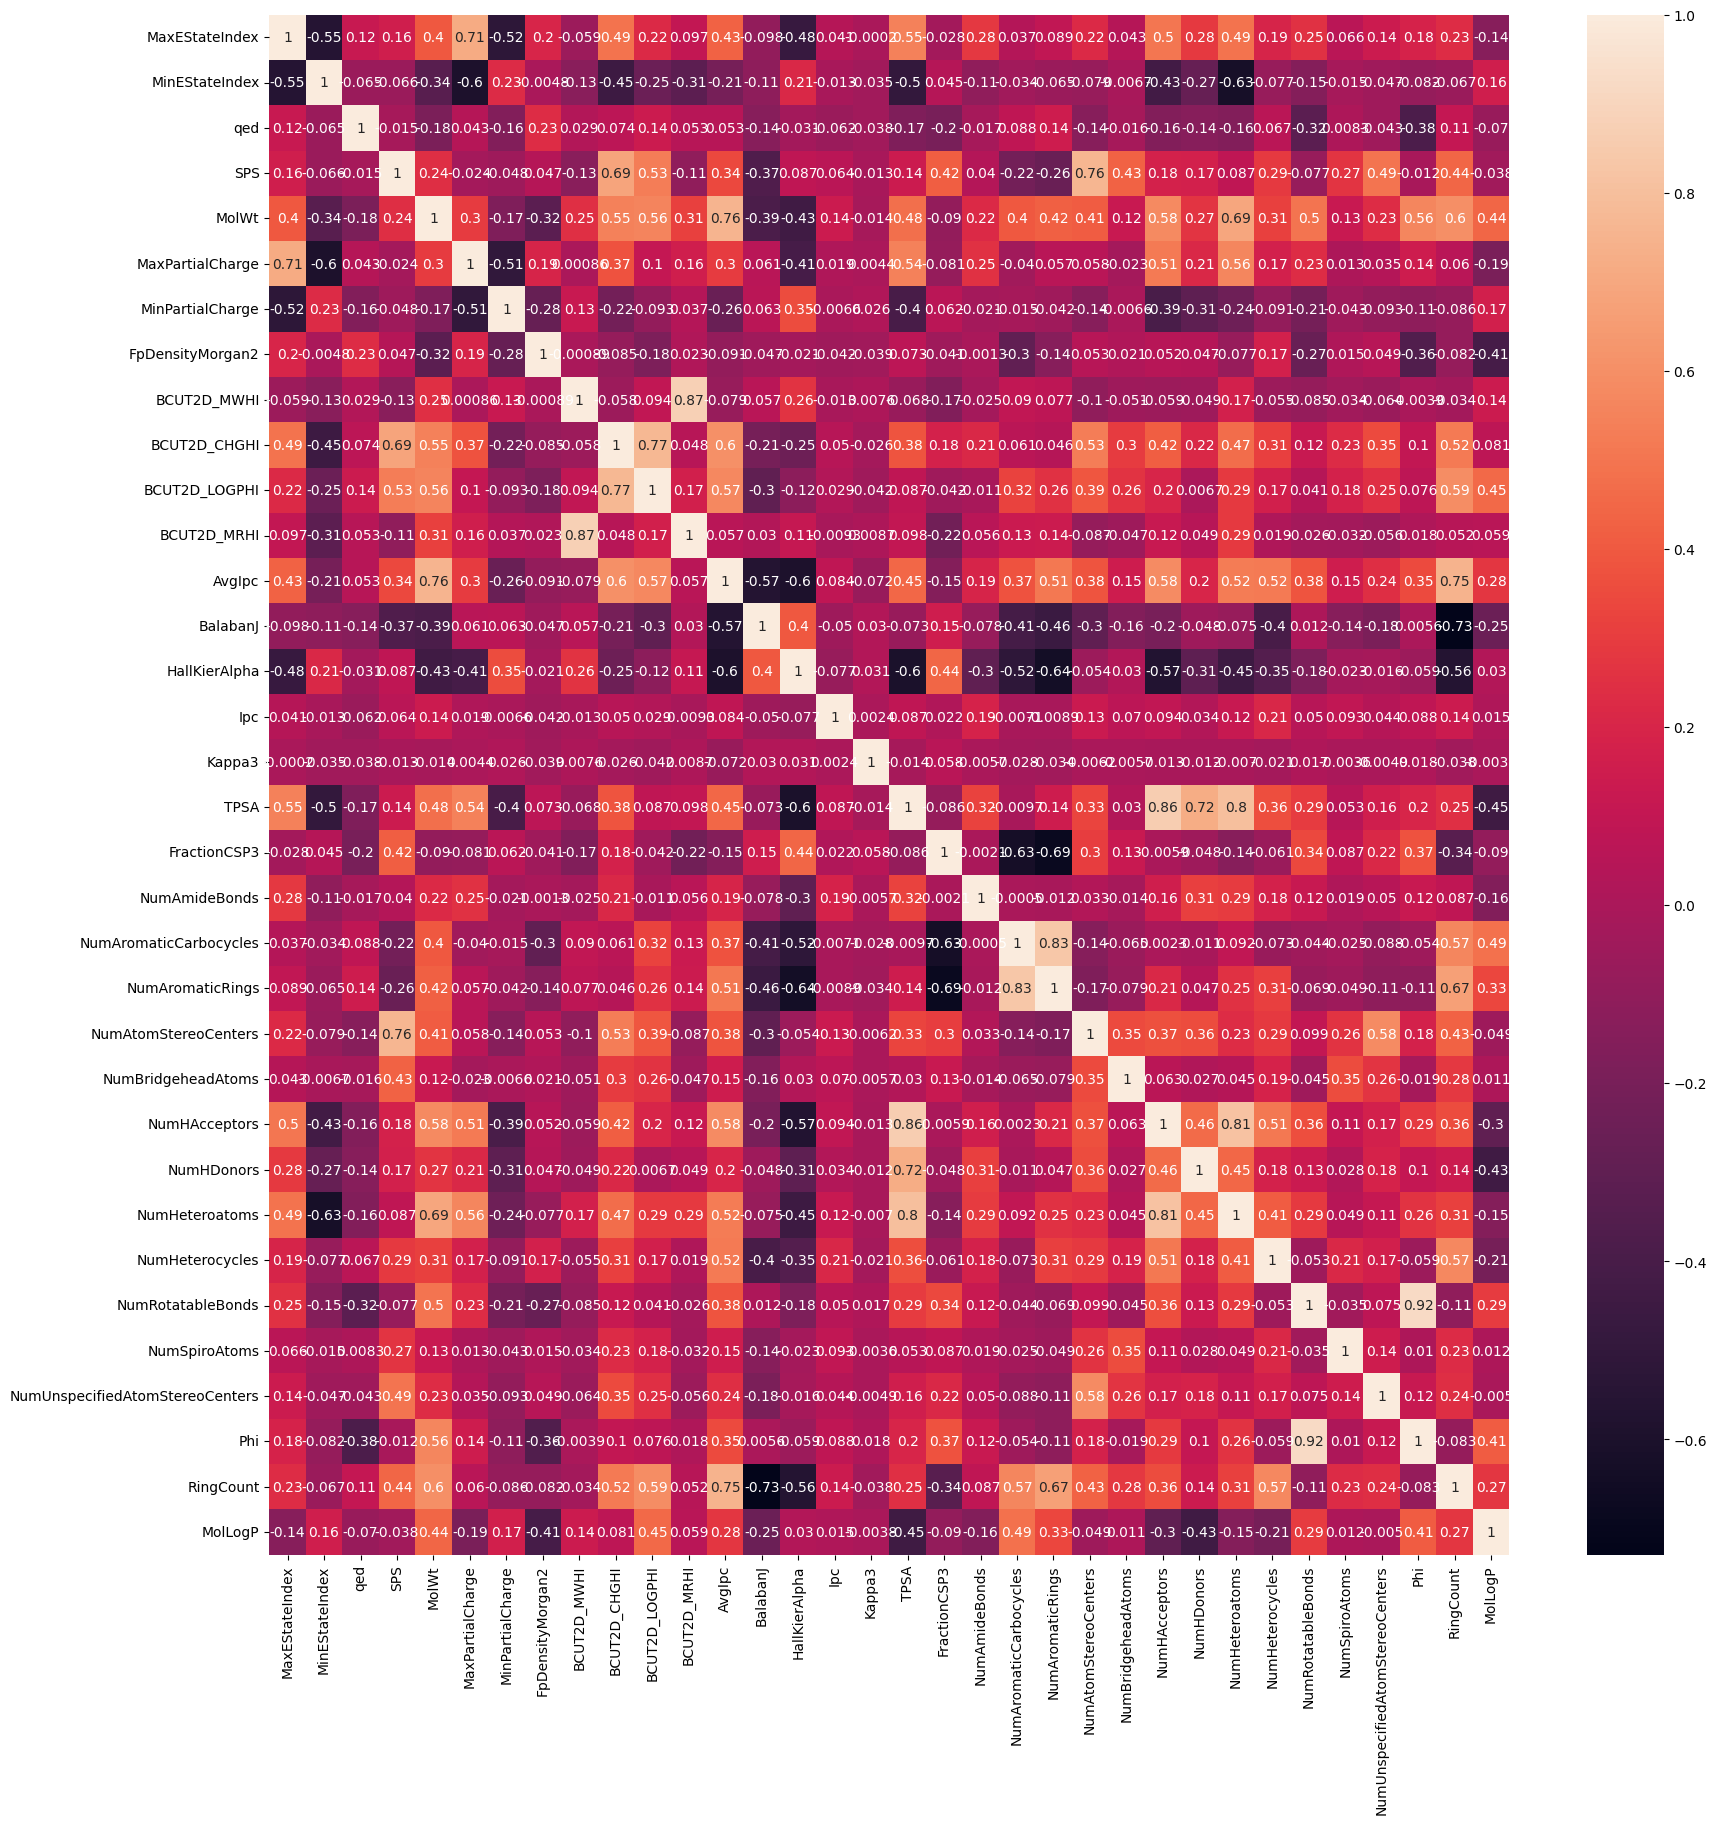

In [ ]:
# view correlation matrix for remaining features
plt.figure(figsize=(20, 20))
sns.heatmap(df_filtered.corr(), annot=True)

In [ ]:
# export features and labels to csv
#df_filtered.to_csv('descriptors.csv', index=False)
#solubility_data_clean[['Y']].to_csv('y_labels.csv', index=False)

## Target Transformation

In [ ]:
print(df_filtered.shape)
print(solubility_target.shape)

(9798, 34)
(9798, 2)


In [13]:
# concatenate labels back onto feature df
solubility_data_clean = pd.concat([df_filtered.reset_index(drop=True), solubility_target], axis=1)
print("Clean dataset shape:", solubility_data_clean.shape)
solubility_data_clean.head()

Clean dataset shape: (9798, 36)


,MaxEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan2,BCUT2D_MWHI,BCUT2D_CHGHI,...,NumHeteroatoms,NumHeterocycles,NumRotatableBonds,NumSpiroAtoms,NumUnspecifiedAtomStereoCenters,Phi,RingCount,MolLogP,Drug,Y
0,9.958604,-0.188056,0.841862,11.714286,284.399,0.120905,-0.507407,0.857143,16.257856,2.252639,...,2.0,0.0,2.0,0.0,0.0,3.749005,2.0,4.65738,Cc1cc(cc(C)c1O)C(C)(C)c2cc(C)c(O)c(C)c2,-4.952869
1,11.383865,-0.017994,0.617490,23.000000,256.386,0.305278,-0.465675,1.111111,16.532541,2.024220,...,3.0,1.0,0.0,0.0,0.0,9.908867,1.0,3.85090,O=C1CCCCCCCCCOCCCCCO1,-3.883849
2,9.657778,-1.038148,0.419190,9.500000,116.080,0.356649,-0.348429,1.250000,16.168129,1.861036,...,6.0,0.0,0.0,0.0,0.0,2.182497,0.0,-0.40400,NC(=O)N=NC(N)=O,-3.546243
3,9.836310,-0.008588,0.680250,12.933333,206.329,0.118819,-0.507654,1.400000,16.255462,2.212512,...,1.0,0.0,0.0,0.0,0.0,2.861488,1.0,3.98720,CC(C)(C)c1ccc(O)c(c1)C(C)(C)C,-3.796046
4,10.535393,0.116191,0.689906,13.600000,204.313,0.122624,-0.303088,1.733333,16.129333,2.124964,...,1.0,0.0,3.0,0.0,1.0,3.673325,1.0,3.36160,CC(Cc1ccc(cc1)C(C)(C)C)C=O,-3.791782


In [14]:
 # convert y labels to categories with ordinal encoding using the following cutoffs:
# < 4 = insoluble
# -4 to -2 = slightly soluble
# > -2 = soluble

# define solubility bins and categories
bins = [-float('inf'), -4, -2, float('inf')]
labels = [0, 1, 2]

# apply binning
solubility_data_clean['sol_category'] = pd.cut(solubility_data_clean['Y'], bins=bins, labels=labels)

## Split Data

In [15]:
# split data into train, test, and validation using stratified split on categorical y
train_raw, temp_df = train_test_split(solubility_data_clean, test_size=0.3, stratify=solubility_data_clean['sol_category'], random_state=7)
valid_raw, test_raw = train_test_split(temp_df, test_size=1/3, stratify=temp_df['sol_category'], random_state=7)

print(f"Train set: {len(train_raw)} samples ({round(len(train_raw)/len(solubility_data_clean)*100, 0)}%)")
print(f"Validation set: {len(valid_raw)} samples ({round(len(valid_raw)/len(solubility_data_clean)*100, 0)}%)")
print(f"Test set: {len(test_raw)} samples ({round(len(test_raw)/len(solubility_data_clean)*100, 0)}%)")

Train set: 6858 samples (70.0%)
Validation set: 1960 samples (20.0%)
Test set: 980 samples (10.0%)


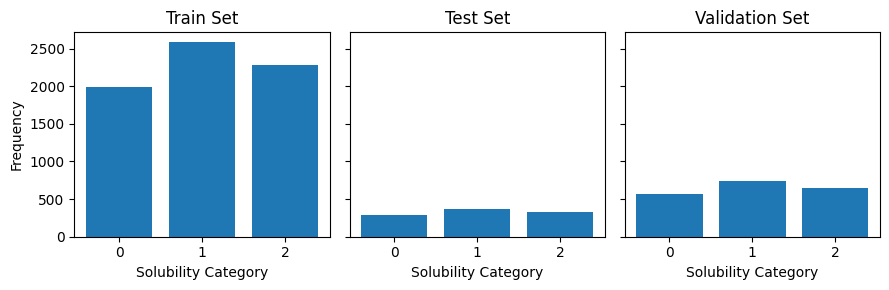

In [16]:
# plot value counts in for each dataset in a separate bar plot
train_counts = train_raw['sol_category'].value_counts()
test_counts = test_raw['sol_category'].value_counts()
valid_counts = valid_raw['sol_category'].value_counts()

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Plot train counts
ax[0].bar(train_counts.index, train_counts.values)
ax[0].set_title('Train Set')
ax[0].set_xlabel('Solubility Category')
ax[0].set_ylabel('Frequency')

# Plot test counts
ax[1].bar(test_counts.index, test_counts.values)
ax[1].set_title('Test Set')
ax[1].set_xlabel('Solubility Category')

# Plot valid counts
ax[2].bar(valid_counts.index, valid_counts.values)
ax[2].set_title('Validation Set')
ax[2].set_xlabel('Solubility Category')

plt.tight_layout()
plt.show()

In [17]:
# split into data and labels
X_train = train_raw.drop(columns=['Y', 'sol_category'], axis=1)
y_train_cat = train_raw['sol_category'].to_numpy()
y_train_num = train_raw['Y'].to_numpy()

X_test = test_raw.drop(columns=['Y', 'sol_category'], axis=1)
y_test_cat = test_raw['sol_category'].to_numpy()
y_test_num = test_raw['Y'].to_numpy()

X_valid = valid_raw.drop(columns=['Y', 'sol_category'], axis=1)
y_valid_cat = valid_raw['sol_category'].to_numpy()
y_valid_num = valid_raw['Y'].to_numpy()

In [18]:
# export X datasets to csv and y to numpy
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
X_valid.to_csv('X_valid.csv', index=False)

np.save('y_train_cat.npy', y_train_cat)
np.save('y_test_cat.npy', y_test_cat)
np.save('y_valid_cat.npy', y_valid_cat)

np.save('y_train_num.npy', y_train_num)
np.save('y_test_num.npy', y_test_num)
np.save('y_valid_num.npy', y_valid_num)

## Feature Standardization

In [ ]:
# standardize X features
X_columns = X_train.columns
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_valid_std = scaler.transform(X_valid)

In [ ]:
# convert scaled arrays back to df
X_train_std = pd.DataFrame(X_train_std, columns=X_columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_columns)
X_valid_std = pd.DataFrame(X_valid_std, columns=X_columns)

In [ ]:
# transform y using Yeo-Johnson power transformer
pt = PowerTransformer(method='yeo-johnson')
y_train_std = pt.fit_transform(y_train_num.reshape(-1, 1))
y_test_std = pt.transform(y_test_num.reshape(-1, 1))
y_valid_std = pt.transform(y_valid_num.reshape(-1, 1))

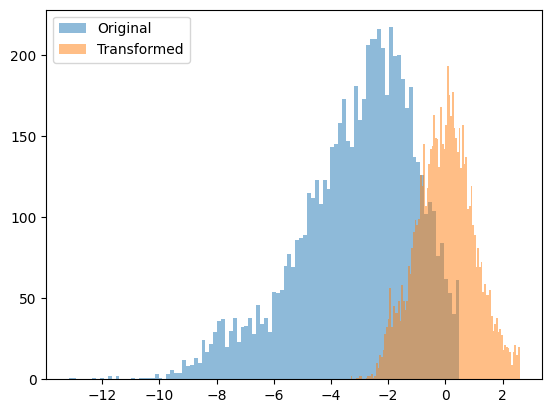

In [ ]:
# show distribution of transformed y compared to original y
plt.hist(y_train_num, bins=100, alpha=0.5, label='Original')
plt.hist(y_train_std, bins=100, alpha=0.5, label='Transformed')
plt.legend()

In [ ]:
# export transformed datasets to np arrays
X_train_std.to_csv('X_train_std.csv', index=False)
X_test_std.to_csv('X_test_std.csv', index=False)
X_valid_std.to_csv('X_valid_std.csv', index=False)

np.save('y_train_num_std.npy', y_train_std)
np.save('y_test_num_std.npy', y_test_std)
np.save('y_valid_num_std.npy', y_valid_std)